# Applying the MaxFilter after identifying bad sensors

## Introduction
The aim of this section is to demonstrate the application of the 'Maxwell filtering' and signal-space separation (SSS). The implementation termed MaxFilter serves to reduce artifacts from both environmental sources and sensor noise. The procedure also performs some fine-tuning and reduces the cross-talk between co-located sensors. Prior to applying the MaxFilter algorithm it is advisable to to remove sensors that are flat or have excessive artifacts ('bad'). If this is not done, it might result in the artifacts from faulty sensors being distributed to other sensors.

Specifically, the SSS is a technique derived from the physics of electromagnetism defined by the Maxwell equations (Taulu and Kajola 2005; Taulu and Simola 2006). The algorithm separates the measured signal into components attributable to sources respectively inside and outside the MEG sensor array. As the internal and external components are linearly independent, it is possible to suppress the contribution from the external components and thus reduce environmental noise sources. Maxwell filtering is a complementary procedure that omits the higher-order components dominated by sensor noise. In MNE-Python Maxwell filtering and SSS are performed by a single function.

## Preparation
First load the relevant Python modules:

In [1]:
import os.path as op
import os
import sys
import numpy as np

import mne
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
import scipy

Define path to the local data and then define the file names:

In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
max_suffix = 'raw_sss'

bids_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX' # path to where you downloaded data
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=meg_suffix, extension='.fif', root=bids_root)

deriv_root = r'C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing' # path to the MaxFilter derivatives folder, with similar BIDS structure as raw data 
deriv_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=meg_suffix, root=deriv_root).mkdir()

deriv_fname = bids_path.basename.replace(meg_suffix, max_suffix) # output filename
deriv_file_1 = op.join(deriv_path.directory, deriv_fname)
deriv_file_2 = deriv_file_1.replace('run-01', 'run-02')
print(deriv_file_2)

C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif


Now define the calibration and cross-talk files. Thes files contains site-specific information relating to sensor orientation and calibration. If you cannot find them, please ask your local experts. The crosstalk compensation file containes parameters used to reduce interference between co-located magnetometer and paired gradiometer sensor units. The calibration file contains information specfic to the local static magnetic fields and gradients. Note that the calibration file will be specific to the position of the MEG system (the angle of the gantry). In this case the gantry angle was 68 degrees (a 'A first look at the data'). 

In [3]:
crosstalk_file = bids_path.meg_crosstalk_fpath
calibration_file = bids_path.meg_calibration_fpath
print(calibration_file)

C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_acq-calibration_meg.dat


Now read the raw data

In [4]:
data1 = read_raw_bids(bids_path=bids_path, 
                     extra_params={'preload':True},
                     verbose=True)

Opening raw data file C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_meg.fif...
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 208000 ... 1664999 =    208.000 ...  1664.999 secs
Ready.
Reading 0 ... 1456999  =      0.000 ...  1456.999 secs...
Reading events from C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_events.tsv.
Reading channel info from C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_channels.tsv.
Dropping cHPI informa

C:\Users\parkh\AppData\Local\Temp\ipykernel_16852\3807992030.py:1: RuntimeWarning: The unit for channel(s) ECG003, EOG001, EOG002, MISC001, MISC002, MISC003 has changed from V to NA.
  data1 = read_raw_bids(bids_path=bids_path,


### Idenfity the faulty sensors
The following scripts automatically identify the faulty sensors:

In [5]:
data1.info['bads'] = []
data1_check = data1.copy()
auto_noisy_chs, auto_flat_chs, auto_scores = mne.preprocessing.find_bad_channels_maxwell(
    data1_check, 
    cross_talk=crosstalk_file, 
    calibration=calibration_file,
    return_scores=True, 
    verbose=True)

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:   24.8s finished


Scanning for bad channels in 291 intervals (5.0 s) ...
102 of 102 magnetometer types replaced with T3.
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-01_ses-01_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Interval   1:    0.000 -    4.999
        Interval   2:    5.000 -    9.999
        Interval   3:   10.000 -   14.999
        Interval   4:   15.000 -   19.999
        Interval   5:   20.000 -   24.999
        Interval   6:   25.000 -   29.999
        Interval   7:   30.000 -   34.999
        Interval   8:   35.000 -   39.999
        Interval   9:   40.000 -   44.999
        Interval  10:   45.000 -   49.999
        Interval  11:   50.000 -   54.999
        Interval  12:   55.000 -   59.999
        Interval  13:   60.000 -   64

Show which channels were detected as noisy and flat:

In [6]:
print('noisy =', auto_noisy_chs)
print('flat =', auto_flat_chs)

noisy = ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']
flat = []


**Question 1:** Where are the noisy sensors located? Identify and mark the sensor on the layout below (adapted from Hu et al., 2018):
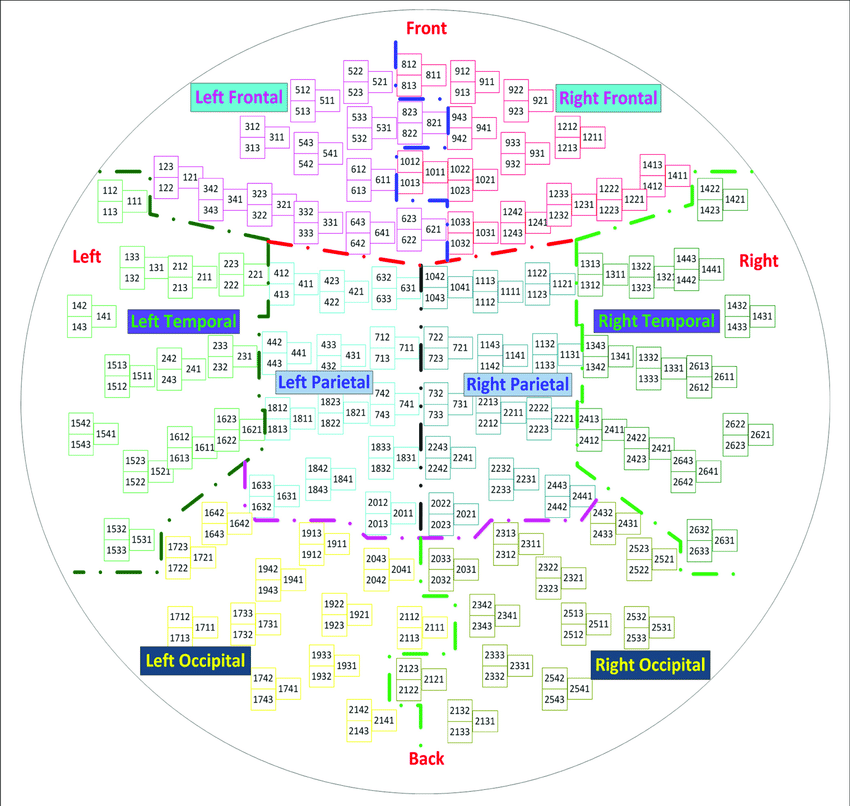


**Question 2:** Plot the time course of a few noisy sensors and compare to non-noisy sensors. What characterizes the noisy sensors?

**Question 3:** What might be causing the noisy sensors and could something be done to reduce the problem for future data acquisitions?

Set the noisy and flat sensors as 'bad' in the data set:

In [7]:
data1.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
print('bads =', data1.info['bads'])

bads = ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']


Change MEGIN magnetometer coil types (type 3022 and 3023 to 3024) to ensure compatibility across systems.

In [8]:
data1.fix_mag_coil_types()

102 of 102 magnetometer types replaced with T3.


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,mne_anonymize
Participant,sub-01
Digitized points,403 points
Good channels,"6 misc, 11 IAS, 99 Magnetometers, 198 Gradiometers, 18 Stimulus, 2 SYST"
Bad channels,"MEG0911, MEG0912, MEG0913, MEG0921, MEG0922, MEG0923, MEG0932, MEG1212, MEG2311"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1000.00 Hz
Highpass,0.10 Hz
Lowpass,330.00 Hz


## Apply the Maxfilter and calibration

Apply the algorithm performing the Maxfiltering, SSS, calibration and cross-talk reduction:

In [9]:
data1_sss = mne.preprocessing.maxwell_filter(
    data1,
    cross_talk=crosstalk_file,
    calibration=calibration_file,
    verbose=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG0911', 'MEG0912', 'MEG0913', 'MEG0921', 'MEG0922', 'MEG0923', 'MEG0932', 'MEG1212', 'MEG2311']
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sub-01_ses-01_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Using 88/95 harmonic components for    0.000  (73/80 in, 15/15 out)
    Using loaded raw data
    Processing 145 data chunks
[done]


Plot the power spectra of raw data:

Effective window size : 1.000 (s)


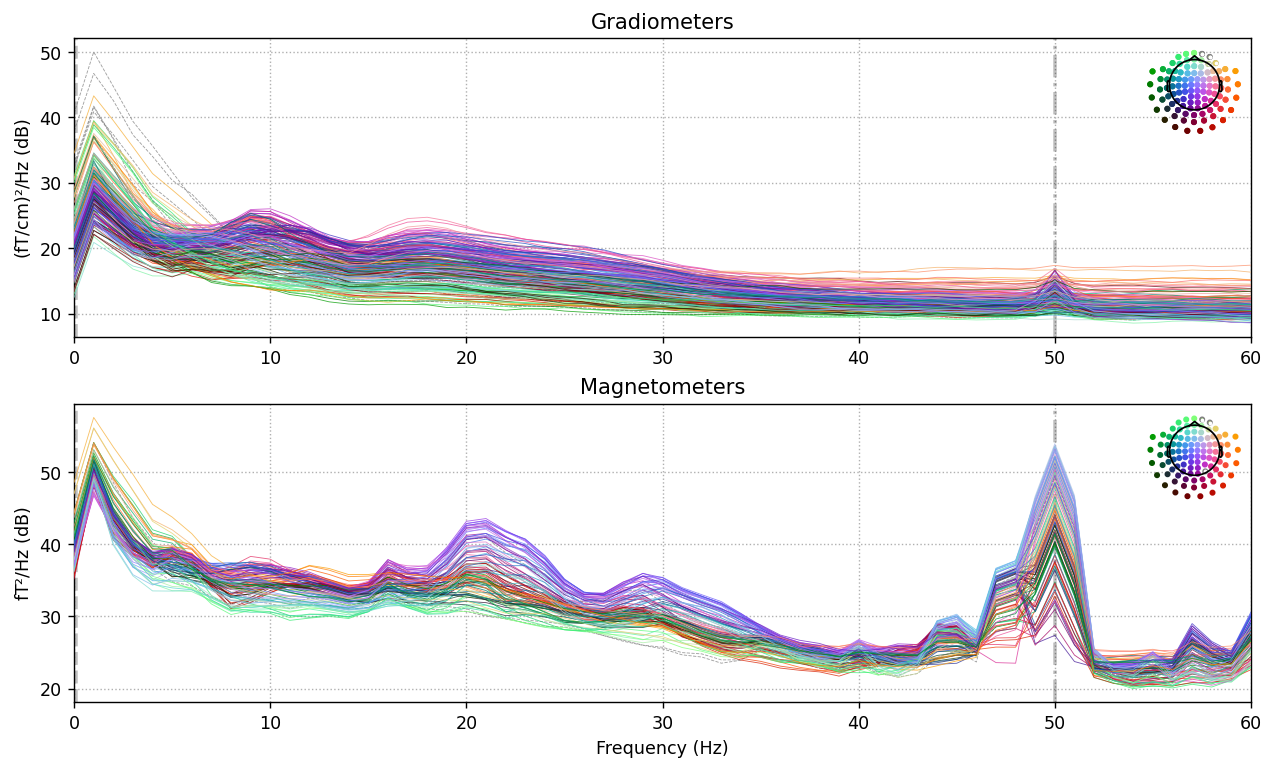

In [14]:
%matplotlib inline
data1.compute_psd(fmax=60, n_fft=1000).plot()

and compared them to the power spectra after the application of the noise reduction algorithms:

Effective window size : 1.000 (s)


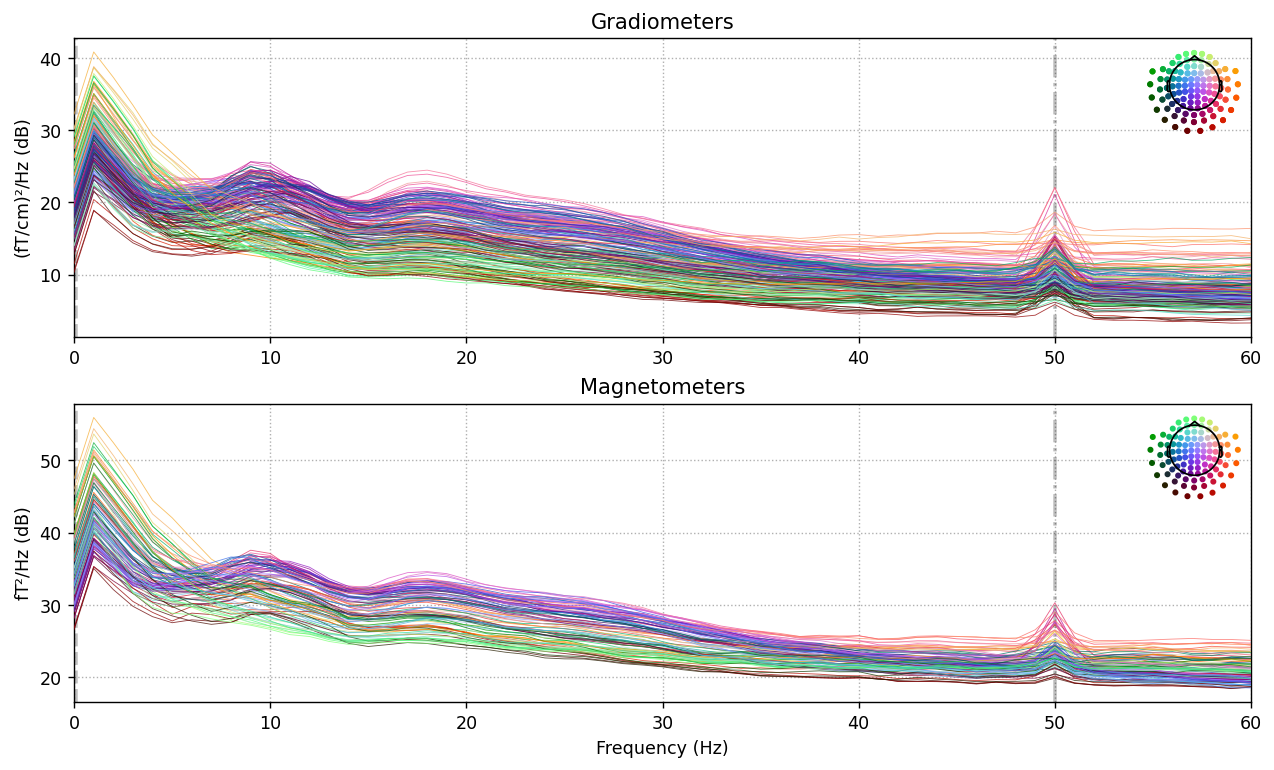

In [15]:
%matplotlib inline
data1_sss.compute_psd(fmax=60, n_fft=1000).plot()

**Question 4:** What are the consequences of the SSS application for the 50 Hz peak of the magnetometers?

**Question 5:** Is the SSS most effective for the gradiometers or the magnetometers? Motivate the answer.


Save the result in a FIF-file. The result_path below is specific to your own setup:

<div class="alert alert-block alert-danger">
<b>Warning:<br />
    </b> If you are using MNE-Python < 1.0, run the code below before saving the SSS data. This will fix an issue with the formatting of the subject information preventing the new data to be saved. 
    <br /> <br />
    <code>data1_sss.info['subject_info']['weight'] = None  
 data1_sss.info['subject_info']['height'] = None</div>

In [16]:
data1_sss.save(deriv_file_1, overwrite=True) 

Overwriting existing file.
Writing C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
Closing C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-01_raw_sss.fif
[done]


To complete the procedure perform the noise reduction procedure for the remaining sub-file. They will be stored in the result_path:

In [17]:
bids_path.update(run='02')
print(bids_path.basename)
data2 = read_raw_bids(bids_path=bids_path, 
                      extra_params={'preload':True},
                      verbose=True)
data2.info['bads'].extend(auto_noisy_chs + auto_flat_chs)
data2.fix_mag_coil_types()
data2_sss = mne.preprocessing.maxwell_filter(data2,
                                             cross_talk=crosstalk_file,                                          
                                             calibration=calibration_file,
                                             verbose=True)
# data2_sss.info['subject_info']['weight'] = None  
# data2_sss.info['subject_info']['height'] = None
data2_sss.save(deriv_file_2, overwrite=True)

sub-01_ses-01_task-SpAtt_run-02_meg.fif
Opening raw data file C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_meg.fif...
    Read a total of 8 projection items:
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
        generated with autossp-1.2.0 (1 x 306)  idle
    Range : 1665000 ... 3098999 =   1665.000 ...  3098.999 secs
Ready.
Reading 0 ... 1433999  =      0.000 ...  1433.999 secs...
Reading events from C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_events.tsv.
Reading channel info from C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_r

C:\Users\parkh\AppData\Local\Temp\ipykernel_16852\2427503492.py:3: RuntimeWarning: The unit for channel(s) ECG003, EOG001, EOG002, MISC001, MISC002, MISC003 has changed from V to NA.
  data2 = read_raw_bids(bids_path=bids_path,


    Using fine calibration sub-01_ses-01_acq-calibration_meg.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.3° ± 0.3° (max: 1.6°)
    Automatic origin fit: head of radius 96.3 mm
    Using origin 0.1, 3.0, 30.2 mm in the head frame
        Using 88/95 harmonic components for    0.000  (73/80 in, 15/15 out)
    Using loaded raw data
    Processing 143 data chunks
[done]
Overwriting existing file.
Writing C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
Closing C:\Users\parkh\MEG Dropbox\Hyojin Park\FLUX\derivatives\Preprocessing\sub-01\ses-01\meg\sub-01_ses-01_task-SpAtt_run-02_raw_sss.fif
[done]


## Preregistration and publication

Preregistration: report the sampling frequency and the properties of the anti-aliasing lowpass filter. Also report the peripheral data to be recorded (e.g. the EOG and ECG)

Publication, example:

"Sensors with excessive artefacts were marked from the data sets using a semi-automatic detection algorithm (about 8 per participant). Subsequently, the Signal-Space Separation (SSS) method  (Taulu et al., 2004) was applied to reduce environmental artefacts. SSS decomposes the data using multiple moments based on spherical harmonics and removes the component of the magnetic field originating from outside the MEG helmet."

## References
Taulu,S. and Kajola, M. (2005) Presentation of electromagnetic multichannel data: the signal space separation method. Journal of Applied Physics, 97(12):124905 doi:10.1063/1.1935742.

Taulu, S. and Simola, J. (2006) Spatiotemporal signal space separation method for rejecting nearby interference in MEG measurements. Physics in Medicine and Biology, 51(7):1759–1768 doi:10.1088/0031-9155/51/7/008.

Hu Y, Yin C, Zhang J, Wang Y. (2018) Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging. Front Neurosci. 12:616